In [15]:
import pickle
import numpy as np
import tensorflow as tf
from xgboost import XGBClassifier
from keras.datasets import fashion_mnist
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [5]:
from sklearn.model_selection import train_test_split
X_train_clf, X_val_clf, y_train_clf, y_val_clf = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [6]:
y_train_clf_encoded = tf.one_hot(y_train_clf, depth = 10)
y_val_clf_encoded = tf.one_hot(y_val_clf, depth = 10)
y_test_clf_encoded = tf.one_hot(y_test, depth = 10)

In [7]:
X_train_rf = X_train_clf.reshape(len(X_train_clf), 784)
X_val_rf = X_val_clf.reshape(len(X_val_clf), 784)
X_test_rf = x_test.reshape(len(x_test), 784)

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
# data_augmentation = tf.keras.Sequential(
#     [
#         tf.keras.layers.RandomFlip("vertical"),
#         tf.keras.layers.RandomRotation(0.1),
#         tf.keras.layers.RandomZoom(0.1),
#     ]
# )

In [9]:
inputs = tf.keras.Input(shape=(28, 28, 1))
# x = data_augmentation(inputs)
x = inputs

x = tf.keras.layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [16, 32, 64, 128, 256, 512, 1024, 2048]:
    residual = x

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("tanh")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("tanh")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("tanh")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("tanh")(x)
    x = tf.keras.layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)


    residual = tf.keras.layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = tf.keras.layers.add([x, residual])

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
clf1 = tf.keras.Model(inputs=inputs, outputs=outputs)

In [10]:
# clf1.summary()

In [11]:
callbacks_list = [
    EarlyStopping(
        monitor="val_accuracy",
        patience=5,
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001),
    ModelCheckpoint(
        filepath="/content/drive/Shareddrives/ECEN_758_Project/xception_batchData_100_reduceLearnPlateau.h5",
        monitor="val_accuracy",
        save_best_only=True,
    )
]

In [12]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=None
)

In [13]:
clf1.compile(loss="CategoricalCrossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "Precision", "Recall"])
history_clf1 = clf1.fit(
    X_train_clf,
    y_train_clf_encoded,
    epochs=50,
    batch_size=64,
    callbacks=callbacks_list,
    validation_data=(X_val_clf, y_val_clf_encoded)
)

Epoch 1/50
480/480 [==============================] - ETA: 0s - loss: 0.5352 - accuracy: 0.8104 - precision: 0.8542 - recall: 0.7724

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


480/480 [==============================] - 67s 69ms/step - loss: 0.5352 - accuracy: 0.8104 - precision: 0.8542 - recall: 0.7724 - val_loss: 0.5707 - val_accuracy: 0.8276 - val_precision: 0.9000 - val_recall: 0.7204 - lr: 0.0010
Epoch 2/50
480/480 [==============================] - 37s 77ms/step - loss: 0.3879 - accuracy: 0.8632 - precision: 0.8881 - recall: 0.8409 - val_loss: 0.3925 - val_accuracy: 0.8586 - val_precision: 0.8850 - val_recall: 0.8405 - lr: 0.0010
Epoch 3/50
480/480 [==============================] - 37s 76ms/step - loss: 0.3361 - accuracy: 0.8829 - precision: 0.9033 - recall: 0.8652 - val_loss: 0.3499 - val_accuracy: 0.8767 - val_precision: 0.8976 - val_recall: 0.8580 - lr: 0.0010
Epoch 4/50
480/480 [==============================] - 31s 64ms/step - loss: 0.3103 - accuracy: 0.8919 - precision: 0.9096 - recall: 0.8766 - val_loss: 0.3696 - val_accuracy: 0.8702 - val_precision: 0.8916 - val_recall: 0.8543 - lr: 0.0010
Epoch 5/50
480/480 [==============================] - 3

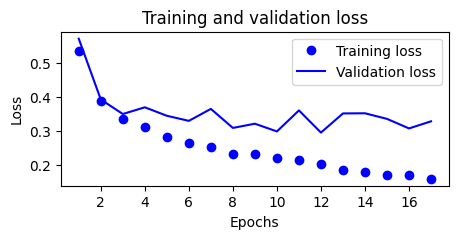

In [14]:
import matplotlib.pyplot as plt

history_clf_dict = history_clf1.history
loss_values = history_clf_dict["loss"]
val_loss_values = history_clf_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.figure(figsize=(5,2))
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

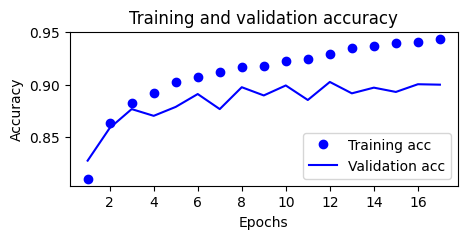

In [15]:
acc = history_clf_dict["accuracy"]
val_acc = history_clf_dict["val_accuracy"]
plt.figure(figsize=(5,2))
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [9]:
xception = tf.keras.saving.load_model('/content/drive/Shareddrives/ECEN_758_Project/xception_batchData_64.h5')

In [12]:
test_loss, test_acc, test_precision, test_recall = xception.evaluate(x_test, y_test_clf_encoded)

accuracy_score = round(test_acc*1000) / 10
precision_score = round(test_precision*1000) / 10
recall_score = round(test_recall*1000) / 10

print(f"accuracy score: {accuracy_score}")
print(f"precison score: {precision_score}")
print(f"recall score: {recall_score}")

313/313 [==============================] - 5s 14ms/step - loss: 0.3579 - accuracy: 0.9043 - precision: 0.9106 - recall: 0.8987
accuracy score: 90.4
precison score: 91.1
recall score: 89.9


In [20]:
xception_test_proba = xception.predict(x_test)
xception_test_labels = []
for i in range(len(xception_test_proba)):
  xception_test_label = np.argmax(xception_test_proba[i])
  xception_test_labels.append(xception_test_label)
# fig, ax = plt.subplots(figsize=(10, 5))
# ConfusionMatrixDisplay.from_predictions(testdata['label'], y_predTest, ax=ax)
# ax.xaxis.set_ticklabels(labels_info.values(), rotation = 90)
# ax.yaxis.set_ticklabels(labels_info.values())
# _ = ax.set_title(
#     f"Confusion Matrix for Random Forest Classifier Test Set"
# )

# print(classification_report(y_test, xception_test_labels))

313/313 [==============================] - 3s 7ms/step


In [15]:
print(classification_report(y_test, xception_test_labels))

              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1000
           1       0.99      0.98      0.98      1000
           2       0.89      0.85      0.87      1000
           3       0.91      0.89      0.90      1000
           4       0.82      0.88      0.85      1000
           5       0.98      0.98      0.98      1000
           6       0.74      0.71      0.72      1000
           7       0.96      0.95      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
xgboost = XGBClassifier(n_estimators=35, max_depth=15, learning_rate=1, device="cuda")

In [ ]:
xgboost.fit(X_train_rf, y_train_clf)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [01:53:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, criterion='gini', device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=35, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
filename = 'xgboost.pkl'
pickle.dump(xgboost,  open(filename, 'wb'))

In [13]:
xgboostStable = pickle.load(open('/content/drive/Shareddrives/ECEN_758_Project/xgboost.pkl', 'rb'))

In [16]:
y_val_rf = xgboostStable.predict(X_val_rf)
xgboost_val_proba = xgboostStable.predict_proba(X_test_rf)

# fig, ax = plt.subplots(figsize=(10, 5))
# ConfusionMatrixDisplay.from_predictions(testdata['label'], y_predTest, ax=ax)
# ax.xaxis.set_ticklabels(labels_info.values(), rotation = 90)
# ax.yaxis.set_ticklabels(labels_info.values())
# _ = ax.set_title(
#     f"Confusion Matrix for Random Forest Classifier Test Set"
# )

print(classification_report(y_val_clf, y_val_rf))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85      1202
           1       0.99      0.98      0.99      1219
           2       0.82      0.85      0.84      1205
           3       0.88      0.93      0.90      1184
           4       0.82      0.85      0.84      1202
           5       0.98      0.97      0.97      1211
           6       0.77      0.65      0.70      1218
           7       0.95      0.96      0.96      1159
           8       0.97      0.97      0.97      1197
           9       0.96      0.97      0.96      1203

    accuracy                           0.90     12000
   macro avg       0.90      0.90      0.90     12000
weighted avg       0.90      0.90      0.90     12000



In [17]:
y_test_rf = xgboostStable.predict(X_test_rf)
xgboost_test_proba = xgboostStable.predict_proba(X_test_rf)

# fig, ax = plt.subplots(figsize=(10, 5))
# ConfusionMatrixDisplay.from_predictions(testdata['label'], y_predTest, ax=ax)
# ax.xaxis.set_ticklabels(labels_info.values(), rotation = 90)
# ax.yaxis.set_ticklabels(labels_info.values())
# _ = ax.set_title(
#     f"Confusion Matrix for Random Forest Classifier Test Set"
# )

print(classification_report(y_test, y_test_rf))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1000
           1       1.00      0.97      0.98      1000
           2       0.79      0.84      0.81      1000
           3       0.89      0.92      0.90      1000
           4       0.80      0.82      0.81      1000
           5       0.98      0.97      0.98      1000
           6       0.74      0.63      0.68      1000
           7       0.95      0.97      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [22]:
def getconflicts(classifier1_labels, classifier2_labels):

  label_conflicts = np.where(np.not_equal(classifier1_labels, classifier2_labels))
  conflicts = []
  for i in label_conflicts[0]:
    conflicts.append(i)

  return conflicts, label_conflicts

In [23]:
conflicts, _ = getconflicts(xception_test_labels, y_test_rf)

In [66]:
xgboost_probas = []
for i in range(len(xgboost_test_proba)):
  xgboost_probas.append(np.max(xgboost_test_proba[i]))

In [ ]:
xgboost_probas

In [39]:
xception_probas = []
for i in range(len(xception_test_proba)):
  xception_probas.append(np.max(xception_test_proba[i]))

In [ ]:
len(xception_probas)

In [79]:
labelconflicts = np.where(np.not_equal(xception_test_labels, y_test_rf))

In [80]:
labelconflicts

(array([], dtype=int64),)

In [30]:
conflicts = []
for i in labelconflicts[0]:
  conflicts.append(i)

In [ ]:
conflicts

In [42]:
xgboost_coflict_labels = []
for i in conflicts:
  xgboost_coflict_labels.append(y_test_rf[i])

In [ ]:
len(xgboost_coflict_labels)

In [45]:
xception_coflict_labels = []
for i in conflicts:
  xception_coflict_labels.append(xception_test_labels[i])

In [ ]:
len(xception_coflict_labels)

In [50]:
xgboost_coflict_probas = []
for i in conflicts:
  xgboost_coflict_probas.append(xgboost_probas[i])

In [ ]:
len(xgboost_coflict_probas)

In [48]:
xception_coflict_probas = []
for i in conflicts:
  xception_coflict_probas.append(xception_probas[i])

In [ ]:
len(xception_coflict_probas)

In [53]:
xg = []
xc = []

for i in range(len(xgboost_coflict_probas)):
  if xgboost_coflict_probas[i] > xception_coflict_probas[i]:
    xg.append(conflicts[i])
  else:
    xc.append(conflicts[i])

In [62]:
final_labels = y_test_rf

for i in xc:
  xc_label = xception_test_labels[i]
  final_labels[i] = xc_label

In [63]:
len(final_labels)

10000

In [64]:
print(classification_report(y_test, final_labels))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1000
           1       0.99      0.98      0.99      1000
           2       0.87      0.87      0.87      1000
           3       0.90      0.91      0.91      1000
           4       0.84      0.88      0.86      1000
           5       0.98      0.98      0.98      1000
           6       0.78      0.71      0.74      1000
           7       0.96      0.97      0.96      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.96      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

